In [4]:
import torch
import lightning as L
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import  train_test_split
from torch import nn
import pandas as pd

### Loading and PreProcessing the Data


txt to csv if needed

In [115]:
import csv

name_open = 'Data.txt'
name_new = 'datatest2.csv'
delimiter = '|'  # Adjust this if your actual delimiter is different

# Read from text file and write to CSV file
with open(name_open, 'r') as f:
    # Read the lines
    lines = f.readlines()

# Extract headers from the first line
headers = [header.strip() for header in lines[0].split(delimiter)]

# Open a new CSV file to write the data
with open(name_new, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, escapechar='\\')  # Specify escapechar to handle special characters
    
    # Write headers
    writer.writerow(headers)

    # Write rows
    for line in lines[1:]:
        row = [item.strip() for item in line.split(delimiter)]
        writer.writerow(row)

print(f"Conversion completed. Data written to {name_new}")


Conversion completed. Data written to datatest2.csv


csv to dataframe

In [119]:
df = pd.read_csv('data/Data2.csv' ,skiprows=1)

df_cleaned = df.dropna(axis=1, how='all')
print(f"Original shape: {df.shape}, Cleaned shape: {df_cleaned.shape}")

df_cleaned

Original shape: (7853, 661), Cleaned shape: (7853, 660)


,"f-act,_/sec","f-sim,_/sec","frame,_time","__cpu,_time","_gpu_,time_","_grnd,ratio","_flit,ratio","_real,_time","_totl,_time","missn,_time",...,"axis4,ratio","axis5,ratio","axis6,ratio","butn1,__sum","butn2,__sum","stick,ratio","gload,req_g","_C*__,____g","_elev,astab.1","_elev,_surf.1"
0,0.17733,19.90000,5.63906,0.00365,0.00223,1.0,1.0,65.12333,0.05025,0.05025,...,-0.01,-0.01,-0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.00007
1,0.19231,22.18968,5.20007,5.19611,0.02947,1.0,1.0,73.18698,0.14557,0.14557,...,-0.01,-0.01,-0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.00057
2,0.24159,21.38992,4.13920,-1.64632,11.65874,1.0,1.0,74.62391,0.24257,0.24257,...,-0.01,-0.01,-0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.00103
3,0.31458,22.31197,3.17882,-1.64632,11.65874,1.0,1.0,74.70666,0.32532,0.32532,...,-0.01,-0.01,-0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.00133
4,0.40920,24.08420,2.44381,-1.64632,11.65874,1.0,1.0,74.79237,0.41103,0.41103,...,-0.01,-0.01,-0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.00158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7848,21.21900,19.90000,0.04713,0.03325,0.05060,1.0,1.0,1014.02081,677.01807,671.60992,...,-0.01,-0.01,-0.01,0.0,0.0,0.0,0.0,0.0,-0.0,0.00963
7849,21.28282,19.90000,0.04699,0.03426,0.04488,1.0,1.0,1014.11407,677.11859,671.71039,...,-0.01,-0.01,-0.01,0.0,0.0,0.0,0.0,0.0,-0.0,0.01047
7850,20.65199,19.90000,0.04842,0.03426,0.04488,1.0,1.0,1014.21991,677.21912,671.81091,...,-0.01,-0.01,-0.01,0.0,0.0,0.0,0.0,0.0,-0.0,0.01132
7851,20.37985,19.90000,0.04907,0.03426,0.04488,1.0,1.0,1014.32275,677.31958,671.91138,...,-0.01,-0.01,-0.01,0.0,0.0,0.0,0.0,0.0,-0.0,0.01216


In [122]:
column_variances = df_cleaned.var() #calculating the variance of each coulmn

#calaculating the diffrences between each row and the one before it in order to find bad samples
df_time = df_cleaned['missn,_time']
df_time
time_diff = df_time.diff()
time_diff
max_time_diff = time_diff.max()
min_time_diff = time_diff.min()
avg_time_diff = time_diff.mean()
most_common_time_diff = time_diff.mode().iloc[0]

print(f'the max time difference is:{max_time_diff}, the min time difference is:{min_time_diff}, the average time difference is:{avg_time_diff} and the common is {most_common_time_diff}')

count_greater_then_given = (time_diff > 0.2).sum()

print(f"Number of time differences greater than 1: {count_greater_then_given}")


the max time difference is:0.15076000000004797, the min time difference is:-5.3091, the average time difference is:0.08558237901171677 and the common is 0.10050000000001091
Number of time differences greater than 1: 0


lets check the variance in all the data sets we currently having. features which got 0 variance in all the datasets we can probably drop

In [157]:
datas_tocheck = ['Data2','Data3','Data4','Data5','Data6']
common_zero_variance_features = None
for data in datas_tocheck:
    df1 = pd.read_csv(f'data/{data}.csv' ,skiprows=1)
    df1_cleaned = df1.dropna(axis=1, how='all')
    print(f"{data} Original shape: {df1.shape}, Cleaned shape: {df1_cleaned.shape}")
    variances = df1_cleaned.var()
    zero_variance_features = variances[variances==0].index.tolist()

    print(f'{data} got {len(zero_variance_features)} features which their variance is 0')

    if common_zero_variance_features is None:
        common_zero_variance_features = set(zero_variance_features)
    else:
        common_zero_variance_features = common_zero_variance_features.intersection(zero_variance_features)

common_zero_variance_features = list(common_zero_variance_features)
print("Common features with zero variance across all datasets:", common_zero_variance_features)
print(len(common_zero_variance_features))


    

Data2 Original shape: (7853, 661), Cleaned shape: (7853, 660)
Data2 got 346 features which their variance is 0
Data3 Original shape: (7423, 661), Cleaned shape: (7423, 660)
Data3 got 349 features which their variance is 0
Data4 Original shape: (8373, 661), Cleaned shape: (8373, 660)
Data4 got 347 features which their variance is 0
Data5 Original shape: (7630, 661), Cleaned shape: (7630, 660)
Data5 got 389 features which their variance is 0
Data6 Original shape: (8008, 661), Cleaned shape: (8008, 660)
Data6 got 408 features which their variance is 0
Common features with zero variance across all datasets: ['_test,_time', '_roll,___lb', '_wind,v_fpm', 'pitot,__ice.1', '__map,range', 'NAV_2,s-crs', '_wind,speed.1', 'alt_4,ftMSL', '_gear,__deg.2', 'cloud,cover.2', '__set,__vvi.1', '_elev,astab.1', '__set,hding', '__alt,air2B', '_snow,ratio', '_rain,_locl', 'lat_5,__deg', '_roll,cycli', 'puffr,power', 'lon_8,__deg', 'fethr,_mode', 'camra,_clou', 'COM_1,_stby', 'load8,___lb', 'stat1,__deg.1',

In [159]:
df2 = pd.read_csv('data/Data2.csv', skiprows=1)
df2 = df2.dropna(axis=1, how='all')
print(f"df2 shape: {df2.shape}")
df2 = df2.drop(common_zero_variance_features, axis=1)
print(f"df2 shape: {df2.shape}")


df2 shape: (7853, 660)
df2 shape: (7853, 330)


In [162]:
test_csv = 'test_csv.csv'
df2.to_csv(test_csv,index=False)

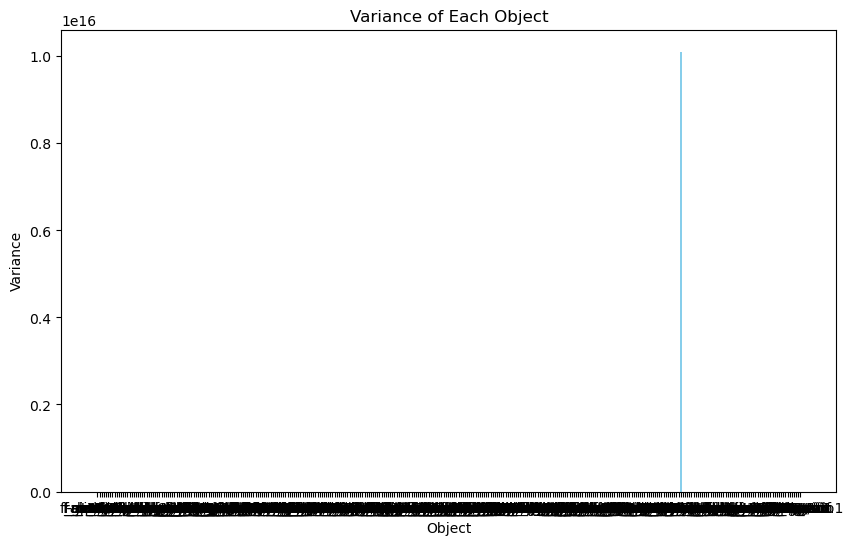

In [160]:
column_variances = df2.var()
names = list(column_variances.keys())
variances = column_variances.tolist()

plt.figure(figsize=(10, 6))
plt.bar(names, variances, color='skyblue')

# Add title and labels
plt.title('Variance of Each Object')
plt.xlabel('Object')
plt.ylabel('Variance')

# Display the plot
plt.show()

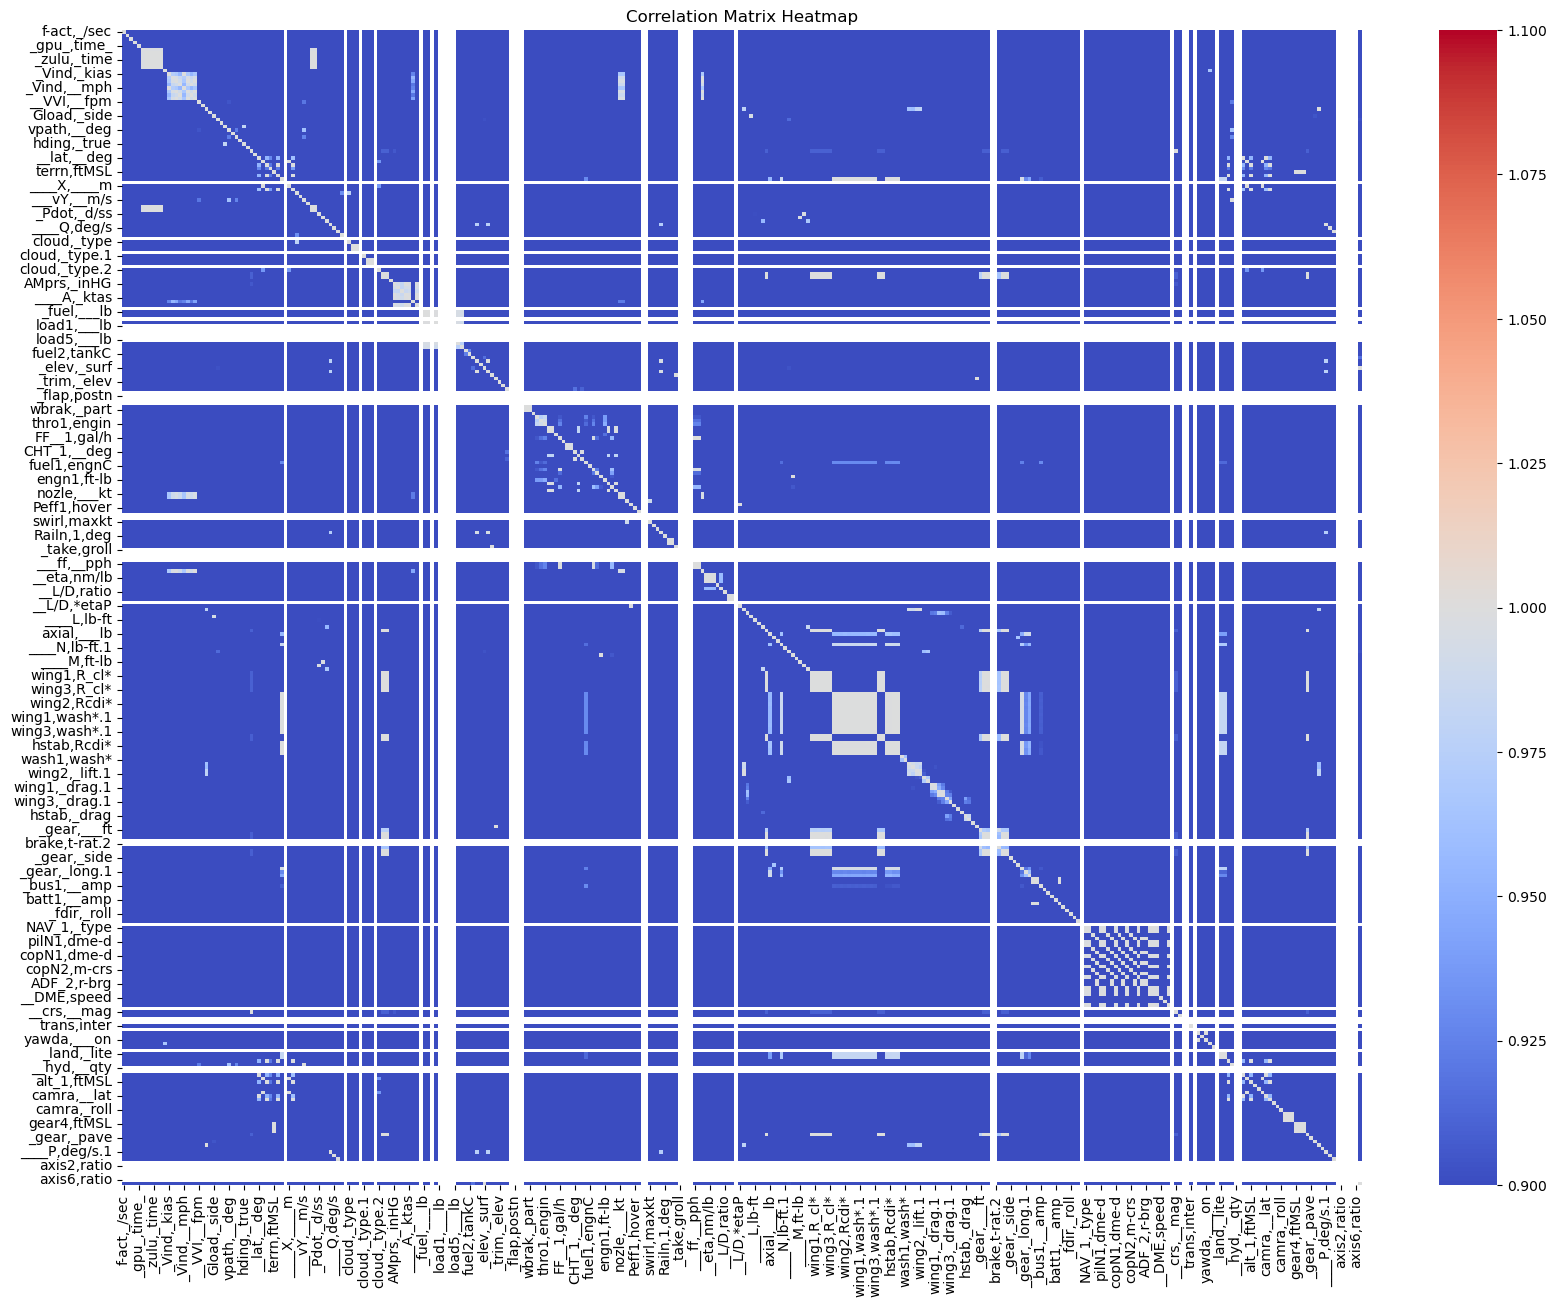

In [161]:
correlation_matrix = df2.corr()


# # Unstack the correlation matrix and sort by absolute correlation values
# correlation_series = correlation_matrix.abs().unstack().sort_values(ascending=False)

# # Remove duplicate pairs (self correlations and mirrored pairs)
# correlation_series = correlation_series[correlation_series < 1].drop_duplicates()

# # Extract the top correlations above a certain threshold (e.g., 0.9)
# threshold = 0.9
# high_correlations = correlation_series[correlation_series > threshold]

# # Print the features with high correlations
# print("Features with high correlations:")
# print(high_correlations)


plt.figure(figsize=(20,15))
sns.heatmap(correlation_matrix, cmap="coolwarm", vmin=1, vmax=1)

plt.title('Correlation Matrix Heatmap')
plt.show()